In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import rcParams
import celerite
from celerite import terms
from celerite.modeling import Model
import warnings
warnings.filterwarnings('ignore')

import re
import jax.numpy as jnp
from jax import grad, jit, partial
import ticktack
from ticktack import fitting
from astropy.table import Table
from tqdm import tqdm
from jax.ops import index_update

rcParams['figure.figsize'] = (10.0, 5.0)

In [2]:
@jit
def sine(t, param):
    prod =  cf.steady_state_production + 0.18 * cf.steady_state_production * jnp.sin(2 * np.pi / 11 * t)
    return prod

Text(0.5, 1.0, 'Correct d14c')

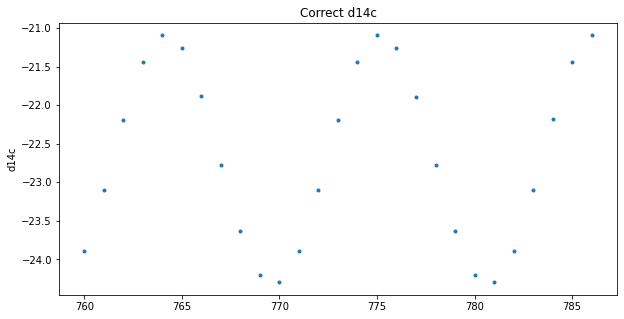

In [38]:
cbm = ticktack.load_presaved_model('Guttler14', production_rate_units = 'atoms/cm^2/s')
cf = fitting.CarbonFitter(cbm)
cf.load_data('inject-recovery.csv')
cf.prepare_function(use_control_points=True)
plt.plot(cf.time_data[:-1], cf.d14c_data[:-1], ".")
plt.ylabel("d14c")
plt.title("Correct d14c")

Text(0.5, 1.0, 'True Production Rate')

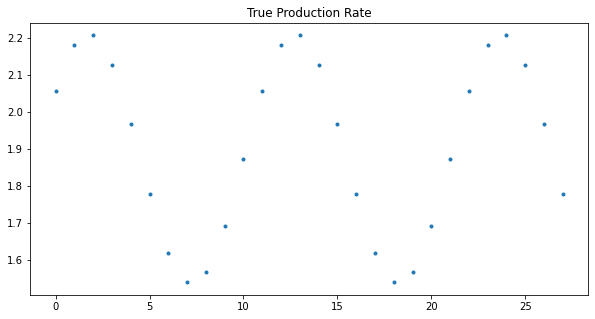

In [44]:
plt.plot(sine(cf.time_data, [1]), ".")
plt.title("True Production Rate")

In [6]:
steady_state = cf.steady_state_production*jnp.ones((len(cf.time_data),))
cf.dc14(steady_state)

DeviceArray([-22.72, -22.72, -22.72, -22.72, -22.72, -22.72, -22.72,
             -22.72, -22.72, -22.72, -22.72, -22.72, -22.72, -22.72,
             -22.72, -22.72, -22.72, -22.72, -22.72, -22.72, -22.72,
             -22.72, -22.72, -22.72, -22.72, -22.72, -22.72],            dtype=float64)

In [32]:
true_prod = sine(jnp.linspace(760, 787, 27), [1])
true_prod

DeviceArray([2.05536888, 2.18277919, 2.20438312, 2.11279966, 1.93931845,
             1.7432097 , 1.59147432, 1.535953  , 1.5956147 , 1.75007589,
             1.94656461, 2.11795011, 2.20567822, 2.17977645, 2.04909419,
             1.85827929, 1.67252403, 1.55529203, 1.54663584, 1.64951286,
             1.82877496, 2.0231769 , 2.16630089, 2.20924835, 2.13734619,
             1.97515992, 1.7781008 ], dtype=float64)

In [9]:
cf.dc14(true_prod)

DeviceArray([ 3.52901263,  3.76451853,  4.09652031,  4.29141598,
              4.13548265,  3.52530844,  2.50954518,  1.27652663,
              0.09455221, -0.77395607, -1.15771832, -1.03162222,
             -0.52591941,  0.11403899,  0.60518708,  0.71532103,
              0.33697452, -0.47927068, -1.54091799, -2.57516006,
             -3.31577614, -3.58763021, -3.36252852, -2.76854256,
             -2.04898886, -1.48571088, -1.30942419], dtype=float64)

Text(0, 0.5, 'd14c')

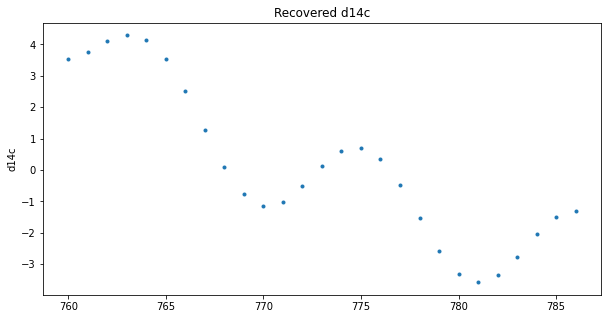

In [42]:
plt.plot(cf.time_data[:-1], cf.dc14(true_prod), ".")
plt.title("Recovered d14c")
plt.ylabel("d14c")

In [46]:
fine_grid_interp = cf.production(cf.time_grid_fine, 2.05536888, 2.17977645, 2.2068128 , 2.12789407, 1.96807642,
             1.7781008 , 1.61828314, 1.53936442, 1.56640077, 1.69080834,
             1.87308861, 2.05536888, 2.17977645, 2.2068128 , 2.12789407,
             1.96807642, 1.7781008 , 1.61828314, 1.53936442, 1.56640077,
             1.69080834, 1.87308861, 2.05536888, 2.17977645, 2.2068128 ,
             2.12789407, 1.96807642, 1.7781008 )

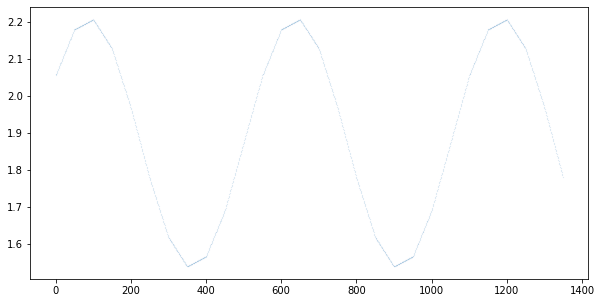

In [47]:
plt.plot(fine_grid_interp, ".", markersize=0.1)

In [ ]:
@jit
def like(params):
    d_14_c = cf.dc14(params)
    lik = jnp.sum((cf.d14c_data[:-1] - d_14_c)**2)
    return lik
@jit
def grad_like(params):
    return jit(grad(like))(params)

gradient = grad_like(steady_state)
# for j in tqdm(range(200)):
#     gradient = grad_like(control_points)
#     gradient = index_update(gradient, gradient<-20, 0)   
#     control_points -= 1e-3*gradient
#     control_points = index_update(control_points, control_points<0, 0)   

In [ ]:
# t = np.linspace(761., 788., 26)[1:]
# plt.plot(t, sine(t, [1]), ".")
# plt.plot(t, steady_state[1:], ".")
# plt.plot(t, gradient[1:]/np.max(np.abs(gradient[1:])), ".")

In [ ]:
# t = np.linspace(761., 787., 26)
# plt.plot(t, sine(t, [1]), ".")
# plt.plot(t, control_points, ".")
# plt.legend(["true", 'recovered'])